# Google ドライブをマウント

In [2]:
from google.colab import drive 
drive.mount('/content/drive')
myfolder = "drive/My Drive/_プロジェクト/CAFE/DATA"

Mounted at /content/drive


# ライブラリ

In [240]:
import pandas as pd
import statistics

import numpy as np
import scipy as sp
from scipy import stats

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

import copy
import math

import matplotlib.pyplot as plt
import seaborn as sns

import collections

# データ
* CAFE_ID :カフェID(1店舗に1番号が付与されている。主キー。)
* STATION_USER :最寄り駅の利用者数(人数)
* MINUTES_FROM_STATION :最寄り駅から徒歩でかかる時間(分)
* COMPETITOR :近隣(駅からカフェまでの道のり+店舗から100m圏内)の競合店舗数 
* AREA :店舗面積
* SHEETS :座席数
* LEADER_AGE :店長の年齢
* WORKERS :従業員数(バイトを含む所属人数、1度のシフトに入る人数ではない)
* MENU :メニュー種類数
* ADS :広告費(月平均額)
* SALES :売上額(円)
* SALES_RANK :売上ランク(会社でつけたA~Eまでのランク。Aは売上が高い。Eは低い。)

In [241]:
df = pd.read_csv(myfolder + "/CAFE.csv")
df.head()

,CAFE_ID,STATION_USER,MINUTES_FROM_STATION,COMPETITOR,AREA,SHEETS,LEADER_AGE,WORKERS,MENU,ADS,SALES,SALES_RANK
0,CAFE0001,58690,2,3,29,16,30,14,19,264803,2956215,E
1,CAFE0002,74627,0,4,33,17,33,14,21,272278,2686770,E
2,CAFE0003,94738,0,4,54,27,29,22,23,265086,4094574,C
3,CAFE0004,97464,0,3,59,31,27,19,23,347455,4754772,B
4,CAFE0005,81798,2,3,50,25,29,16,21,289238,4393329,C


In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CAFE_ID               128 non-null    object
 1   STATION_USER          128 non-null    int64 
 2   MINUTES_FROM_STATION  128 non-null    int64 
 3   COMPETITOR            128 non-null    int64 
 4   AREA                  128 non-null    int64 
 5   SHEETS                128 non-null    int64 
 6   LEADER_AGE            128 non-null    int64 
 7   WORKERS               128 non-null    int64 
 8   MENU                  128 non-null    int64 
 9   ADS                   128 non-null    int64 
 10  SALES                 128 non-null    int64 
 11  SALES_RANK            128 non-null    object
dtypes: int64(10), object(2)
memory usage: 12.1+ KB


In [243]:
df.describe()

,STATION_USER,MINUTES_FROM_STATION,COMPETITOR,AREA,SHEETS,LEADER_AGE,WORKERS,MENU,ADS,SALES
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,1.280000e+02
mean,78191.609375,1.148438,3.062500,54.695312,28.695312,30.070312,19.234375,20.500000,302335.148438,4.353853e+06
std,21520.811263,0.870242,0.858033,10.859561,5.642302,2.074151,4.024501,3.324924,50269.011049,7.721717e+05
min,31404.000000,0.000000,2.000000,29.000000,16.000000,26.000000,11.000000,14.000000,171116.000000,2.686770e+06
25%,62155.250000,1.000000,2.000000,47.000000,25.000000,29.000000,16.000000,18.000000,271002.750000,3.838247e+06
50%,78999.500000,1.000000,3.000000,54.000000,29.000000,30.000000,19.000000,20.000000,298047.500000,4.360999e+06
75%,94851.000000,2.000000,4.000000,61.000000,32.250000,31.000000,22.000000,23.000000,330986.000000,4.786499e+06
max,136056.000000,4.000000,5.000000,86.000000,47.000000,36.000000,27.000000,27.000000,418527.000000,6.793403e+06


# グラス

In [93]:
# 度数集計を実施する
cafe_sales_rank_count = pd.DataFrame( df['SALES_RANK'].value_counts() ).reset_index().sort_values("index")
cafe_sales_rank_count

,index,SALES_RANK
3,A,7
2,B,30
0,C,54
1,D,32
4,E,5


In [94]:
# クロス集計を実施する
cafe_summary = pd.pivot_table( df, values="CAFE_ID",index="MINUTES_FROM_STATION", columns="SALES_RANK", aggfunc='count').reset_index().fillna(0)
cafe_summary

SALES_RANK,MINUTES_FROM_STATION,A,B,C,D,E
0,0,0.0,4.0,14.0,10.0,2.0
1,1,1.0,13.0,24.0,18.0,2.0
2,2,6.0,8.0,14.0,3.0,1.0
3,3,0.0,4.0,2.0,1.0,0.0
4,4,0.0,1.0,0.0,0.0,0.0


# 可視化

## 折れ線

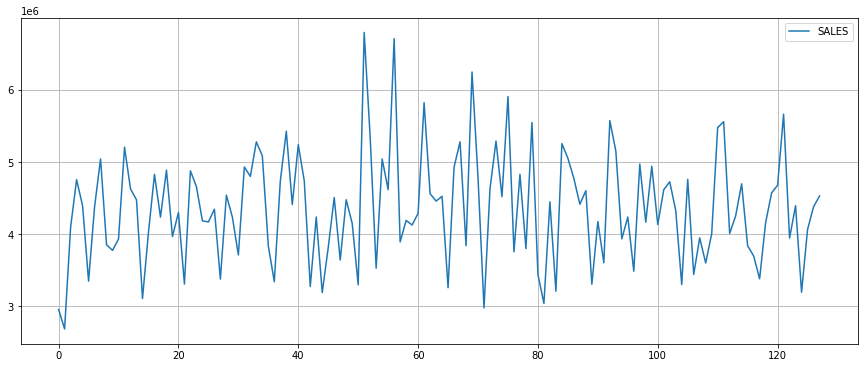

In [149]:
# 300~600万円ぐらいの範囲 内で、いろんな売上のカフェがあることがわかる。
df["SALES"].plot(figsize=(15,6), legend='best', grid=True )

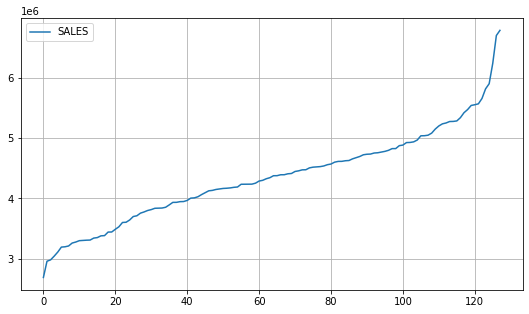

In [150]:
# 一部、異常に売上が 高い店が存在する。
# 一部、売上が振るわない店が存在する。
df.sort_values("SALES").reset_index()["SALES"].plot(figsize=(9,5), legend='best', grid=True )

## 棒グラフ

  index  SALES_RANK
3     A           7
2     B          30
0     C          54
1     D          32
4     E           5


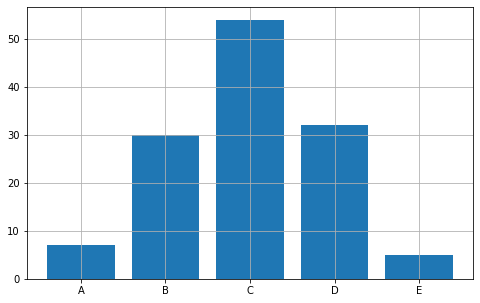

In [152]:
# C ランクのカフェが最も多くついでBとD、最後にAとEが続くことがみえる。
# 度数集計を実施する
barchart = pd.DataFrame( df['SALES_RANK'].value_counts() ).reset_index().sort_values("index")
print(barchart)

plt.figure(figsize=(8,5))
plt.bar( barchart["index"], barchart["SALES_RANK"])
plt.grid(True)
plt.show()

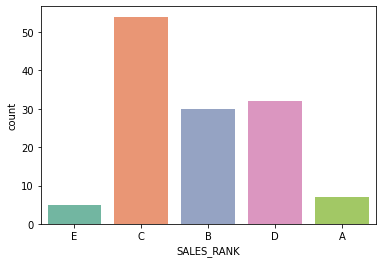

In [98]:
# 棒グラフ（件数カウント）を描画する
# C ランクのカフェが最も多く ついでBとD最後にAとEが続くことがみえる。
sns.countplot(x=df['SALES_RANK'], palette='Set2')

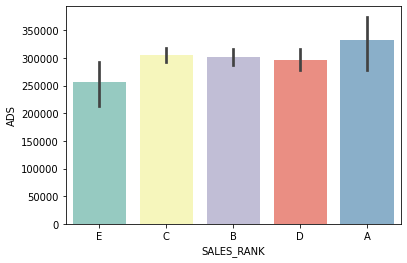

In [99]:
# 棒グラフ（平均値）を描画する
# Aは広告予算が最も高く、Eは低いです。 
#しかしそれ以外の3つについてはC > B > D の順序になっていて、
#必ずしも「広告の量が多い=売上が高い」というわけではなさそうです。
 
sns.barplot(x='SALES_RANK', y='ADS', data=df, palette='Set3')

## 積み上げ棒グラフ

SALES_RANK  MINUTES_FROM_STATION    A     B     C     D    E
0                              0  0.0   4.0  14.0  10.0  2.0
1                              1  1.0  13.0  24.0  18.0  2.0
2                              2  6.0   8.0  14.0   3.0  1.0
3                              3  0.0   4.0   2.0   1.0  0.0
4                              4  0.0   1.0   0.0   0.0  0.0


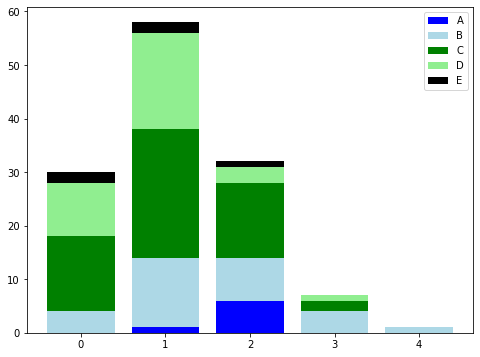

In [155]:
# A ランクは駅から2分ぐらいの場所に多いことがわかった。
# クロス集計を実施する
cafe_summary = pd.pivot_table( df, values="CAFE_ID",index="MINUTES_FROM_STATION", columns="SALES_RANK", aggfunc='count').reset_index().fillna(0)
print(cafe_summary)

# 積み上げ棒グラフを描画する
plt.figure(figsize=(8,6))
p1 = plt.bar( cafe_summary["MINUTES_FROM_STATION"], cafe_summary["A"], color="blue" )
p2 = plt.bar( cafe_summary["MINUTES_FROM_STATION"], cafe_summary["B"], bottom=cafe_summary["A"], color="lightblue" )
p3 = plt.bar( cafe_summary["MINUTES_FROM_STATION"], cafe_summary["C"], bottom=cafe_summary["A"] + cafe_summary["B"], color="green" )
p4 = plt.bar( cafe_summary["MINUTES_FROM_STATION"], cafe_summary["D"], bottom=cafe_summary["A"] + cafe_summary["B"] + cafe_summary["C"], color="lightgreen" )
p5 = plt.bar( cafe_summary["MINUTES_FROM_STATION"], cafe_summary["E"], bottom=cafe_summary["A"] + cafe_summary["B"] + cafe_summary["C"] + cafe_summary["D"], color="Black" )
plt.legend( (p1[0], p2[0], p3[0], p4[0], p5[0]), ("A","B","C","D","E") )
plt.show()

## ヒストグラム

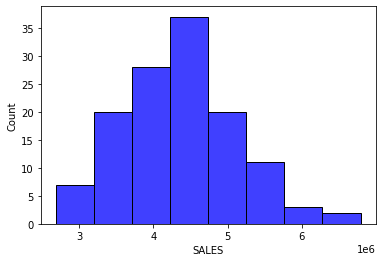

In [101]:
# 最も多いのは450万円前後。まれに600万円をこえる店も存在する。
sns.histplot(df['SALES'], kde=False, bins=8, color='blue')

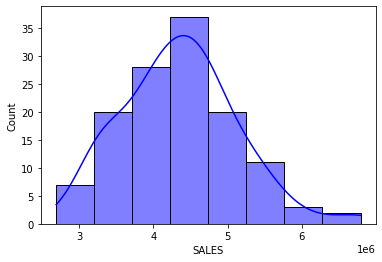

In [102]:
# ヒストグラムを描画する（カーネル密度推定も利用）
sns.histplot(df['SALES'], kde=True, bins=8, color='blue')

## 散布図

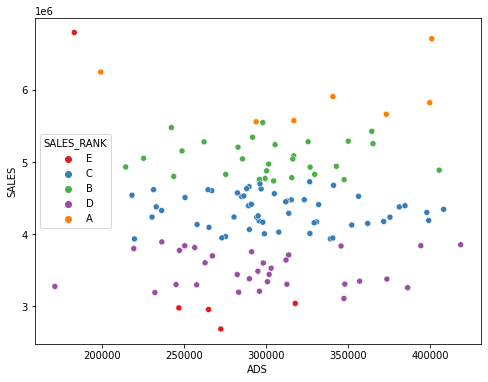

In [156]:
# 点の密度の高いところをみると概要が把握できます。
# 広告予算が増えたからといって売上が高くなるわけではなさそうです。
plt.figure(figsize=(8,6))
sns.scatterplot(x='ADS', y='SALES', hue='SALES_RANK', data=df, palette='Set1')
#plt.scatter(df["SALES"], df["SALES_RANK"], c='blue')

## 散布図+ヒストグラム 

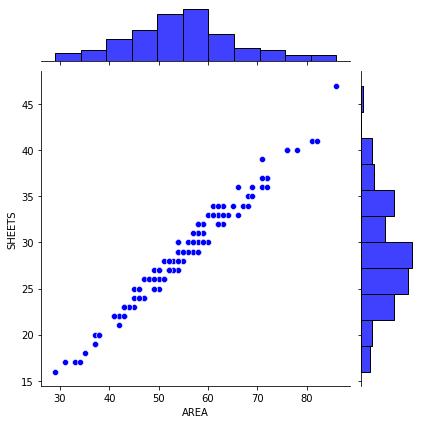

In [104]:
# 店舗面積と座席数は「店舗面積が広くなると 座席も増える」という関係にある事がわかる。 
# 一方、それぞれの分布は互いに(似ては いるが)異なる形をしている。
sns.jointplot(x='AREA', y='SHEETS', data=df, color='blue')

## ペアプロット図

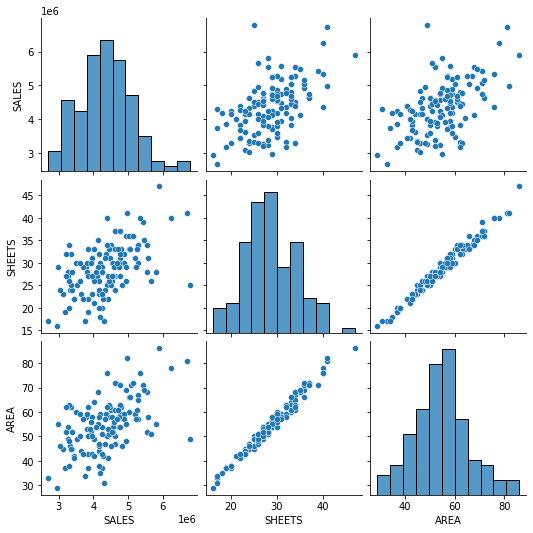

In [105]:
# 売上、店舗面積、座席数の3変数の中では店舗面積-座席数というペアが最も関連が高そうであることがわかる。
cafe_sample = df[["SALES","SALES_RANK","SHEETS","AREA"]]
sns.pairplot(cafe_sample)

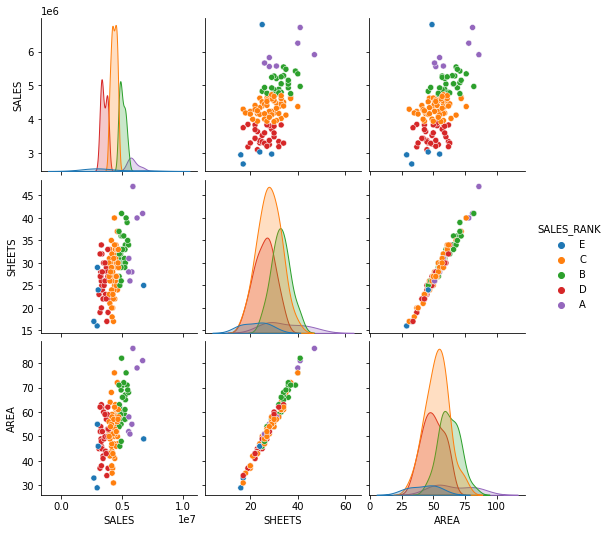

In [106]:
cafe_sample = df[["SALES","SALES_RANK","SHEETS","AREA"]]
sns.pairplot(cafe_sample, hue='SALES_RANK')

## ヒートマップ

SALES_RANK    A     B     C     D    E
0           0.0   4.0  14.0  10.0  2.0
1           1.0  13.0  24.0  18.0  2.0
2           6.0   8.0  14.0   3.0  1.0
3           0.0   4.0   2.0   1.0  0.0
4           0.0   1.0   0.0   0.0  0.0


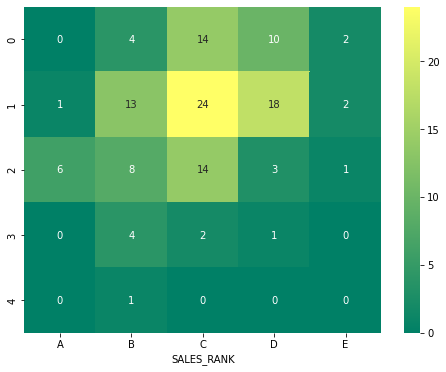

In [157]:
# 最も多い店舗パターンは「駅から 徒歩1分の場所」、「Cランク」である。
# クロス集計を実施する
cafe_summary = pd.pivot_table( df, values="CAFE_ID",index="MINUTES_FROM_STATION", columns="SALES_RANK", aggfunc='count').reset_index().fillna(0)
cafe_summary = cafe_summary[["A","B","C","D","E"]]
print(cafe_summary)
# ヒートマップを描画する
plt.figure(figsize=(8,6))
sns.heatmap(cafe_summary, annot=True, cmap='summer')

## 箱ひげ図

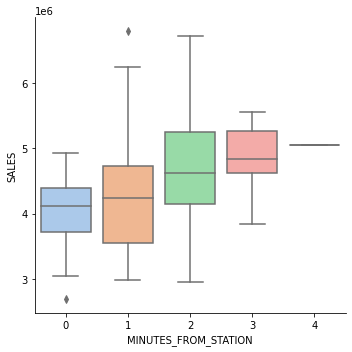

In [108]:
# 箱ひげ図
sns.catplot(x='MINUTES_FROM_STATION',y='SALES', data=df, kind='box', palette='pastel')

## バリエーション

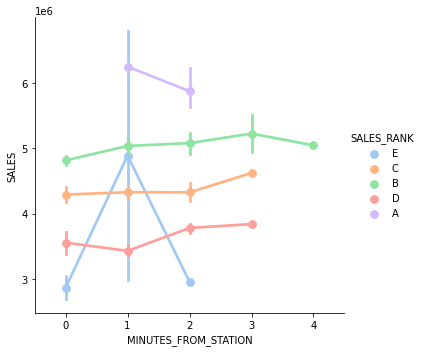

In [109]:
# catplotのバリエーション
sns.catplot(x='MINUTES_FROM_STATION',y='SALES', hue='SALES_RANK', data=df, kind='point', palette='pastel')

## catplotのバリエーション

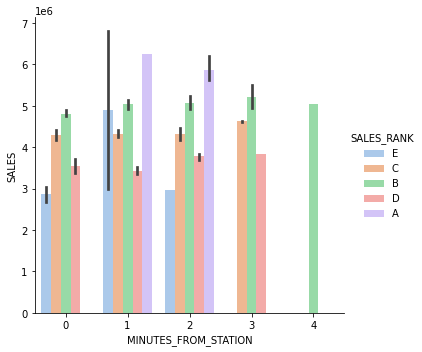

In [110]:
# catplotのバリエーション
sns.catplot(x='MINUTES_FROM_STATION', y='SALES', hue='SALES_RANK', data=df, kind='bar', palette='pastel')

# 統計学

## 統計学

In [244]:
columnList = df.columns.values.tolist()
columnList.remove("CAFE_ID")
columnList.remove("SALES_RANK")
df_ = df.loc[:,columnList]
x_ = df_.columns.values
#最頻値
mode_stat_list = []
for x in x_:
    mode_stat = collections.Counter(df_[x]).most_common()[0][0]
    mode_stat_list.append(mode_stat)
#中央値
median_list = []
for x in x_:
    median = statistics.median(df_[x])
    median_list.append(median)
#平均値
mean_list = []
for x in x_:
    mean = round(statistics.mean(df_[x]),2)
    mean_list.append(mean)
#分散
variance_list = []
for x in x_:
    variance = round(statistics.pvariance(df_[x]),2)
    variance_list.append(variance)
#標準偏差
pstdev_list = []
for x in x_:
    pstdev = round(statistics.pstdev(df_[x]),2)
    pstdev_list.append(pstdev)
#歪度
skew_list = []
for x in x_:
    skew = round(df_[x].skew(),2)
    skew_list.append(skew)
#尖度
kurt_list = []
for x in x_:
    kurt = round(df_[x].kurt(),2)
    kurt_list.append(kurt)
mode = pd.DataFrame(mode_stat_list,index=df_.columns, columns=['mode'])
variance = pd.DataFrame(variance_list,index=df_.columns, columns=['variance'])
median = pd.DataFrame(median_list,index=df_.columns, columns=['median'])
mean = pd.DataFrame(mean_list,index=df_.columns, columns=['mean'])
pstdev = pd.DataFrame(pstdev_list,index=df_.columns, columns=['pstdev'])
skew = pd.DataFrame(skew_list,index=df_.columns, columns=['skew'])
kurt = pd.DataFrame(kurt_list,index=df_.columns, columns=['kurt'])
_df = mode.join(median)
_df = _df.join(mean)
_df = _df.join(variance)
_df = _df.join(pstdev)
_df = _df.join(skew)
_df = _df.join(kurt)
statistics = _df.astype(str).T
statistics

,STATION_USER,MINUTES_FROM_STATION,COMPETITOR,AREA,SHEETS,LEADER_AGE,WORKERS,MENU,ADS,SALES
mode,58690,1,3,54,27,30,19,19,264803,2956215
median,78999.5,1.0,3.0,54.0,29.0,30.0,19.0,20.0,298047.5,4360999.0
mean,78191.61,1.15,3.06,54.7,28.7,30.07,19.23,20.5,302335.15,4353852.74
variance,459526994.61,0.75,0.73,117.01,31.59,4.27,16.07,10.97,2507231491.6,591590918608.71
pstdev,21436.58,0.87,0.85,10.82,5.62,2.07,4.01,3.31,50072.26,769149.48
skew,-0.06,0.51,0.18,0.24,0.21,0.46,-0.16,-0.06,0.08,0.42
kurt,-0.25,0.06,-1.0,0.22,0.29,0.29,-0.74,-0.75,-0.12,0.43


## 相関行列

In [112]:
corr_matrix = df.corr(method='pearson')
corr_matrix

,STATION_USER,MINUTES_FROM_STATION,COMPETITOR,AREA,SHEETS,LEADER_AGE,WORKERS,MENU,ADS,SALES
STATION_USER,1.000000,-0.039170,0.025798,0.006185,0.018481,-0.015788,0.018650,-0.194966,0.056203,0.593643
MINUTES_FROM_STATION,-0.039170,1.000000,0.071839,0.138967,0.139176,0.085781,-0.001019,-0.047623,-0.021193,0.356304
COMPETITOR,0.025798,0.071839,1.000000,-0.193146,-0.168437,-0.175039,0.068692,-0.011040,0.109287,-0.199797
AREA,0.006185,0.138967,-0.193146,1.000000,0.987465,0.028226,-0.009163,0.101513,-0.132454,0.543425
SHEETS,0.018481,0.139176,-0.168437,0.987465,1.000000,0.011264,0.004903,0.096745,-0.122158,0.538182
LEADER_AGE,-0.015788,0.085781,-0.175039,0.028226,0.011264,1.000000,-0.010479,0.055375,0.016346,0.008695
WORKERS,0.018650,-0.001019,0.068692,-0.009163,0.004903,-0.010479,1.000000,-0.175944,0.055008,0.065518
MENU,-0.194966,-0.047623,-0.011040,0.101513,0.096745,0.055375,-0.175944,1.000000,-0.015535,-0.057707
ADS,0.056203,-0.021193,0.109287,-0.132454,-0.122158,0.016346,0.055008,-0.015535,1.000000,0.059247
SALES,0.593643,0.356304,-0.199797,0.543425,0.538182,0.008695,0.065518,-0.057707,0.059247,1.000000


### ヒートマップ化

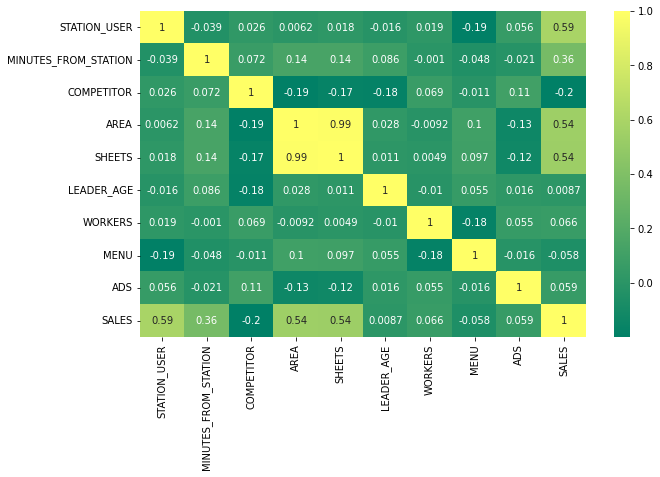

In [113]:
#グラフの大きさ
plt.figure(figsize=(10,6))
#相関行列をヒートマップ化し、相関の高いペアを探索  spring  summer  autumn  winter
sns.heatmap(corr_matrix, annot=True, cmap="summer")

## 共分散行列

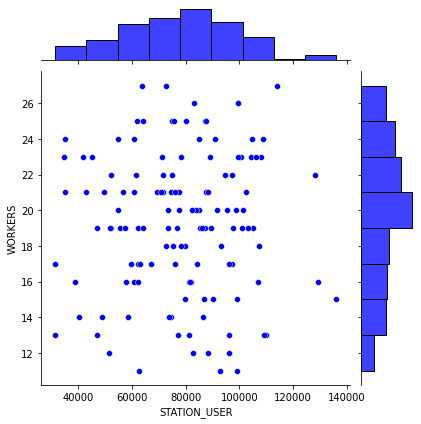

In [114]:
np.cov( df["STATION_USER"], df["WORKERS"], bias=True)
sns.jointplot(x='STATION_USER', y='WORKERS',data=df, color='blue')

## 相関係数

In [115]:
np.corrcoef(df["STATION_USER"], df["WORKERS"])

array([[1.        , 0.01864994],
       [0.01864994, 1.        ]])

## 散布図

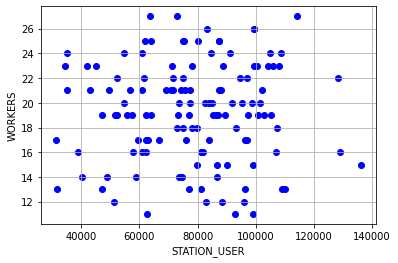

In [116]:
plt.xlabel('STATION_USER')
plt.ylabel('WORKERS')
plt.scatter(df["STATION_USER"], df["WORKERS"], c='blue')
plt.grid(True)
plt.show()

# 回帰分析

In [117]:
# 回帰分析のためのインスタンスをつくる
reg = linear_model.LinearRegression()

# データフレームを目的変数(y)、説明変数(X)に分ける。
X = df.loc[:,["STATION_USER"]]
y = df.loc[:,["WORKERS"]]

## 単回帰分析(回帰係数、切片)

In [118]:
# 単回帰分析を実行する
reg.fit(X, y)
# 分析結果として、回帰係数（reg.coef_）、切片（reg.intercept_）を表示する
print(reg.coef_[0])
print(reg.intercept_[0])

[3.48763377e-06]
18.9616713025118


## 決定係数

In [119]:
# 決定係数を計算する
reg.score(X, y)

0.0003478204025124665

## 散布図と回帰直線

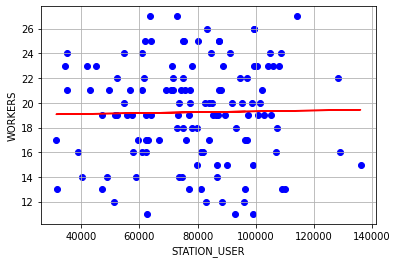

In [120]:
# 散布図と回帰直線を描画する
plt.xlabel('STATION_USER')
plt.ylabel('WORKERS')
plt.scatter(X, y, c='blue')
plt.plot(X, reg.predict(X), c='red')
plt.grid(True)
plt.show()

# 重回帰分析

## 標準化

In [121]:
# 標準化の対象とする変数のリストを作成
columnList = ["COMPETITOR","ADS","SALES"]
# 標準化を実施（結果は heightWeight_std とする）
scaler = StandardScaler()
scaler.fit( df[columnList] )
cafe_std = pd.DataFrame(scaler.transform(df[columnList]), columns=columnList)
cafe_std

,COMPETITOR,ADS,SALES
0,-0.073127,-0.749560,-1.817121
1,1.096909,-0.600275,-2.167437
2,1.096909,-0.743908,-0.337098
3,-0.073127,0.901095,0.521250
4,-0.073127,-0.261565,0.051325
...,...,...,...
123,-1.243163,1.642463,0.052003
124,-0.073127,-0.382610,-1.505041
125,1.096909,-0.252378,-0.376971
126,-1.243163,-1.386799,0.031551


## 回帰分析

In [122]:
# 回帰分析のためのインスタンスをつくる
reg = linear_model.LinearRegression()
# 標準化された変数を基にデータフレームを目的変数(y)、説明変数(X)に分ける。
X = cafe_std.loc[:,["COMPETITOR","ADS"]]
y = cafe_std.loc[:,["SALES"]]

## 単回帰分析(回帰係数、切片)

In [123]:
# 単回帰分析を実行する
reg.fit(X, y)
# 分析結果として、回帰係数（reg.coef_）、切片（reg.intercept_）を表示する
print(reg.coef_[0])
print(reg.intercept_[0])

[-0.20876491  0.08206211]
5.75279105917221e-18


## 決定係数

In [124]:
# 決定係数を計算する
reg.score(X, y)

0.046572436831668895

# 多重共線性
多重共線性 → 標準化 → 相関行列 → VIF → 抜き → 回帰分析 → 減らしながら重回帰分析を実行する（説明変数偏回帰係数、切片、決定係数）

## 標準化

In [125]:
# 標準化の対象とする変数のリストを作成
columnList = ["STATION_USER","MINUTES_FROM_STATION","COMPETITOR","AREA","SHEETS","LEADER_AGE","WORKERS","MENU","ADS","SALES"]
# 標準化を実施（結果は heightWeight_std とする）
scaler = StandardScaler()
scaler.fit( df[columnList] )
cafe_std = pd.DataFrame(scaler.transform(df[columnList]), columns=columnList)
cafe_std.describe()

,STATION_USER,MINUTES_FROM_STATION,COMPETITOR,AREA,SHEETS,LEADER_AGE,WORKERS,MENU,ADS,SALES
count,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.280000e+02
mean,-1.474515e-17,-4.510281e-17,-1.500536e-16,6.938894e-18,3.469447e-18,-4.163336e-17,1.561251e-17,3.469447e-18,-1.951564e-17,-2.298509e-17
std,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00,1.003929e+00
min,-2.182606e+00,-1.324862e+00,-1.243163e+00,-2.375444e+00,-2.258865e+00,-1.970110e+00,-2.054101e+00,-1.962614e+00,-2.620596e+00,-2.167437e+00
25%,-7.480838e-01,-1.712407e-01,-1.243163e+00,-7.114054e-01,-6.575034e-01,-5.180519e-01,-8.068290e-01,-7.548514e-01,-6.257436e-01,-6.703583e-01
50%,3.768748e-02,-1.712407e-01,-7.312724e-02,-6.427927e-02,5.421275e-02,-3.403261e-02,-5.846587e-02,-1.509703e-01,-8.562921e-02,9.291117e-03
75%,7.771478e-01,9.823807e-01,1.096909e+00,5.828468e-01,6.324821e-01,4.499867e-01,6.898973e-01,7.548514e-01,5.721901e-01,5.624993e-01
max,2.699329e+00,3.289624e+00,2.266945e+00,2.894011e+00,3.256935e+00,2.870083e+00,1.937169e+00,1.962614e+00,2.320483e+00,3.171751e+00


## 相関行列

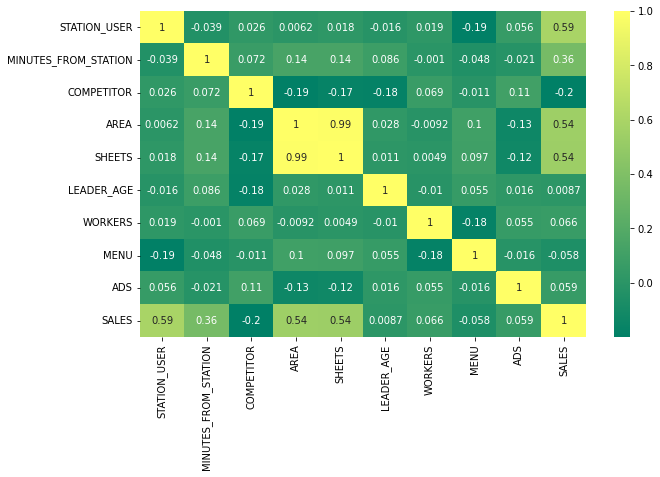

In [126]:
# 相関行列を作成する
plt.figure(figsize=(10,6))
tmp_columnList = ["STATION_USER","MINUTES_FROM_STATION","COMPETITOR","AREA","SHEETS","LEADER_AGE","WORKERS","MENU","ADS","SALES"]
tmp_X = cafe_std[tmp_columnList]
sns.heatmap( tmp_X.corr(), annot=True, cmap="summer")

## VIF

In [127]:
# 投入したデータセットの全ての変数についてVIFを計算する関数 checkVIF の定義
def checkVIF( ExplanatoryVarDataSet ):
  tmp_columnList = ExplanatoryVarDataSet.columns
  vifList = []
  for i in range(len(tmp_columnList)):
    colname = tmp_columnList[i]
    vif = variance_inflation_factor(ExplanatoryVarDataSet.values, i)
    vifList.append( [ colname, vif ] )
  return  pd.DataFrame( vifList, columns=["COLUMN","VIF"] )

In [128]:
# VIFを確認する
tmp_columnList = ["STATION_USER","MINUTES_FROM_STATION","COMPETITOR","AREA","SHEETS","LEADER_AGE","WORKERS","MENU","ADS","SALES"]
tmp_X = cafe_std[tmp_columnList]
vif = checkVIF(tmp_X)
vif

,COLUMN,VIF
0,STATION_USER,2.768596
1,MINUTES_FROM_STATION,1.572331
2,COMPETITOR,1.251631
3,AREA,44.498567
4,SHEETS,42.074341
5,LEADER_AGE,1.073025
6,WORKERS,1.072747
7,MENU,1.105752
8,ADS,1.092768
9,SALES,4.588969


## SHEETSを抜き

In [129]:
# VIFを確認する、SHEETSを抜き
tmp_columnList = ["STATION_USER","MINUTES_FROM_STATION","COMPETITOR","AREA","LEADER_AGE","WORKERS","MENU","ADS","SALES"]
tmp_X = cafe_std[tmp_columnList]
tmp_X_corr = pd.DataFrame( tmp_X.corr().loc["SALES"] ).reset_index()
tmp_X_corr["SALES_ABS"] = abs(tmp_X_corr["SALES"])
tmp_X_corr = tmp_X_corr.sort_values("SALES_ABS")
init_columnList = tmp_X_corr["index"].to_list()
init_columnList.remove("SALES")
init_columnList

['LEADER_AGE',
 'MENU',
 'ADS',
 'WORKERS',
 'COMPETITOR',
 'MINUTES_FROM_STATION',
 'AREA',
 'STATION_USER']

## 回帰分析

In [130]:
# 回帰分析のためのインスタンスをつくる
reg = linear_model.LinearRegression()

## 変数を徐々に減らしながら重回帰分析

In [131]:
# 変数を徐々に減らしながら重回帰分析を実行する
for i in range(len(init_columnList)):
  # 変数を選択する（iが増えるごとに前の方の変数＝相関係数の絶対値が低い変数が失われる）
  tmp_columnList = init_columnList[i:len(init_columnList)]
  X = cafe_std.loc[:,tmp_columnList]
  y = cafe_std.loc[:,["SALES"]]
  # 単回帰分析を実行する
  reg.fit(X, y)
  # 分析結果として、回帰係数（reg.coef_）、切片（reg.intercept_）、決定係数（reg.score）を表示する
  print("-------------------------------------------")
  print( "説明変数：" + str(tmp_columnList))
  print( "偏回帰係数：" + str(reg.coef_[0]))
  print( "切片：" + str(reg.intercept_[0]) )
  print( "決定係数：" + str(reg.score(X, y)) )

-------------------------------------------
説明変数：['LEADER_AGE', 'MENU', 'ADS', 'WORKERS', 'COMPETITOR', 'MINUTES_FROM_STATION', 'AREA', 'STATION_USER']
偏回帰係数：[-0.05815278  0.04482457  0.11148514  0.07202603 -0.17544236  0.33678636
  0.47148982  0.60865694]
切片：-1.6908557209883664e-18
決定係数：0.7808273280226128
-------------------------------------------
説明変数：['MENU', 'ADS', 'WORKERS', 'COMPETITOR', 'MINUTES_FROM_STATION', 'AREA', 'STATION_USER']
偏回帰係数：[ 0.04108478  0.10937087  0.07133884 -0.16428891  0.33055983  0.4729626
  0.60843681]
切片：-5.819389928412593e-19
決定係数：0.7776011885755421
-------------------------------------------
説明変数：['ADS', 'WORKERS', 'COMPETITOR', 'MINUTES_FROM_STATION', 'AREA', 'STATION_USER']
偏回帰係数：[ 0.11002239  0.06417495 -0.16294243  0.32751144  0.47788767  0.60033905]
切片：1.1971323590408144e-18
決定係数：0.7760553571275346
-------------------------------------------
説明変数：['WORKERS', 'COMPETITOR', 'MINUTES_FROM_STATION', 'AREA', 'STATION_USER']
偏回帰係数：[ 0.06937229 -0.1538008

# まとめ

## 定義

In [132]:
# VIFを計算する関数 checkVIF の定義     checkVIF
def checkVIF( ExplanatoryVarDataSet ):
  tmp_columnList = ExplanatoryVarDataSet.columns
  vifList = []
  for i in range(len(tmp_columnList)):
    colname = tmp_columnList[i]
    vif = variance_inflation_factor(ExplanatoryVarDataSet.values, i)
    vifList.append( [ colname, vif ] )
  return  pd.DataFrame( vifList, columns=["COLUMN","VIF"] )

In [133]:
# 自由度調整済み決定係数を計算する関数     calcAdjR2
#TSS(総変動) - ESS(回帰変動) = RSS(残差変動)
def calcAdjR2(x, y_data, y_predict):
  colNum = len(x.columns)
  rowNum = x.count()[0]
  y_data = y_data.values
  TSS = ( y_data * y_data ).sum()  
  ESS = ( y_predict * y_predict ).sum()
  RSS = TSS - ESS
  AdjR2 = 1 - ( RSS / TSS ) * ( (rowNum - 1) / (rowNum - colNum - 1) )
  return AdjR2

In [134]:
# ステップワイズ法で変数選択された重回帰分析を実行する関数   LR_stepwise_AdjR2
def LR_stepwise_AdjR2(X, y, maxIter=100):

  # 回帰分析のためのインスタンスをつくる
  reg = linear_model.LinearRegression()
  returnReg = linear_model.LinearRegression()

  # 最終モデルの項目リストを定義しておく
  orgColList = X.columns
  modelColList = []
  maxR2modelColList = []
  modelCoef = 0
  modelIntercept = 0
  modelR2 = 0
  modelAdjR2 = 0
  residueColList = copy.copy(orgColList)
  # 
  count = 0
  while count < maxIter:
    count = count + 1
    for i in range(len(residueColList)):
      tmpColList = copy.copy(modelColList)
      if residueColList[i] in tmpColList:
        if len(tmpColList) > 1:
          tmpColList.remove( residueColList[i] )
        else:
          continue
      else:
        tmpColList.append( residueColList[i] )
      tmp_X = X.loc[:,tmpColList]
      reg.fit(tmp_X, y)
      if modelAdjR2 < calcAdjR2(tmp_X, y, reg.predict(tmp_X) ):
        maxR2modelColList = copy.copy(tmpColList)
        modelR2 = reg.score(tmp_X, y)
        modelAdjR2 = calcAdjR2(tmp_X, y, reg.predict(tmp_X) )
        print("model update: variables:" + str(maxR2modelColList) + ", Adjusted R-Square: " + str(modelAdjR2) )
        returnReg = copy.copy(reg)
    modelColList = copy.copy(maxR2modelColList)
  return returnReg, modelColList

In [135]:
# AICを計算する関数     calcAIC
def calcAIC(x, y_data, y_predict):
  colNum = len(x.columns)
  rowNum = x.count()[0]
  y_data = y_data.values
  RSS = ( ( y_data - y_predict ) * ( y_data - y_predict ) ).sum()
  AIC = rowNum * ( math.log( 2 * math.pi * RSS / rowNum ) + 1 ) + 2 * ( colNum + 2 )
  return AIC

In [136]:
# AICを基準としたステップワイズ法で変数選択された重回帰分析を実行する関数       LR_stepwise_AIC
def LR_stepwise_AIC(X, y, maxIter=100):

  # 回帰分析のためのインスタンスをつくる
  reg = linear_model.LinearRegression()
  returnReg = linear_model.LinearRegression()
  
  # 最終モデルの項目リストを定義しておく
  orgColList = X.columns
  modelColList = []
  maxR2modelColList = []
  modelCoef = 0
  modelIntercept = 0
  modelR2 = 0
  modelAIC = 1000000000
  residueColList = copy.copy(orgColList)
  # 
  count = 0
  while count < maxIter:
    count = count + 1
    for i in range(len(residueColList)):
      tmpColList = copy.copy(modelColList)
      if residueColList[i] in tmpColList:
        if len(tmpColList) > 1:
          tmpColList.remove( residueColList[i] )
        else:
          continue
      else:
        tmpColList.append( residueColList[i] )
      tmp_X = X.loc[:,tmpColList]
      reg.fit(tmp_X, y)
      if modelAIC > calcAIC(tmp_X, y, reg.predict(tmp_X) ):
        maxR2modelColList = copy.copy(tmpColList)
        modelR2 = reg.score(tmp_X, y)
        modelAIC = calcAIC(tmp_X, y, reg.predict(tmp_X) )
        print("model update: variables:" + str(maxR2modelColList) + ", AIC: " + str(modelAIC) )
        returnReg = copy.copy(reg)
    modelColList = copy.copy(maxR2modelColList)
  return returnReg, modelColList

## 分割

In [137]:
# 目的変数と説明変数に分割
columnList = ["STATION_USER","MINUTES_FROM_STATION","COMPETITOR","AREA","SHEETS","LEADER_AGE","WORKERS","MENU","ADS"]
X = df.loc[:,columnList]
y = df.loc[:,["SALES"]]

# モデル構築用データ、モデル検証用データに分割（50:50に分割）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(64, 9)
(64, 9)
(64, 1)
(64, 1)


## 標準化

In [138]:
# X_train、X_test に対して標準化を実施
scaler_X = StandardScaler()
scaler_X.fit( X_train )
X_train_std = pd.DataFrame(scaler_X.transform(X_train), columns=columnList)
X_test_std = pd.DataFrame(scaler_X.transform(X_test), columns=columnList)

In [139]:
# y_train、y_test に対して標準化を実施
scaler_y = StandardScaler()
scaler_y.fit( y_train )
y_train_std = pd.DataFrame(scaler_y.transform(y_train), columns=["SALES"])
y_test_std = pd.DataFrame(scaler_y.transform(y_test), columns=["SALES"])

## ステップワイズ法

In [140]:
#ステップワイズ法で変数選択をしつつ重回帰分析を実行する
reg, colList = LR_stepwise_AdjR2(X_train_std, y_train_std, maxIter=10)

model update: variables:['STATION_USER'], Adjusted R-Square: 0.1271519163689443
model update: variables:['MINUTES_FROM_STATION'], Adjusted R-Square: 0.20710163854078456
model update: variables:['AREA'], Adjusted R-Square: 0.2591440247011215
model update: variables:['AREA', 'STATION_USER'], Adjusted R-Square: 0.44072526575573423
model update: variables:['AREA', 'STATION_USER', 'MINUTES_FROM_STATION'], Adjusted R-Square: 0.5420908063001986
model update: variables:['AREA', 'STATION_USER', 'MINUTES_FROM_STATION', 'COMPETITOR'], Adjusted R-Square: 0.5628949452617673
model update: variables:['AREA', 'STATION_USER', 'MINUTES_FROM_STATION', 'COMPETITOR', 'LEADER_AGE'], Adjusted R-Square: 0.576367090496794


## 回帰係数、切片

In [141]:
# 分析結果として、回帰係数（reg.coef_）、切片（reg.intercept_）と共に、
# 多重共線性を確認して表示する
result = pd.DataFrame( [ colList + ["intercept"]  , reg.coef_[0].tolist() + [reg.intercept_[0]] ] ).T
result.columns = ["COLUMN","COEF"]
vif = checkVIF(X_train_std[colList])
pd.merge( result, vif, on="COLUMN", how="outer")

,COLUMN,COEF,VIF
0,AREA,0.41693,1.161750
1,STATION_USER,0.451338,1.018544
2,MINUTES_FROM_STATION,0.374971,1.153095
3,COMPETITOR,-0.185343,1.046378
4,LEADER_AGE,-0.142214,1.045696
5,intercept,0.0,NaN


## 決定係数

In [142]:
# モデル構築用データについて決定係数を計算する
reg.score(X_train_std[colList], y_train_std)

0.6099887499811751

In [143]:
# モデル検証用データについて決定係数を計算する
reg.score(X_test_std[colList], y_test_std)

0.8487809418518203

## 多重共線性（AREAを抜く）

In [144]:
# 多重共線性、一部の変数を削除した変数リストを作成する（AREAを抜く）
columnList2 = ["STATION_USER","MINUTES_FROM_STATION","COMPETITOR","SHEETS","LEADER_AGE","WORKERS","MENU","ADS"]

In [145]:
# 変数を削除した、モデルを構築
reg, colList = LR_stepwise_AdjR2(X_train_std.loc[:,columnList2], y_train_std, maxIter=10)

model update: variables:['STATION_USER'], Adjusted R-Square: 0.1271519163689443
model update: variables:['MINUTES_FROM_STATION'], Adjusted R-Square: 0.20710163854078456
model update: variables:['SHEETS'], Adjusted R-Square: 0.25282172751790033
model update: variables:['SHEETS', 'STATION_USER'], Adjusted R-Square: 0.4266324603946128
model update: variables:['SHEETS', 'STATION_USER', 'MINUTES_FROM_STATION'], Adjusted R-Square: 0.5311275095905892
model update: variables:['SHEETS', 'STATION_USER', 'MINUTES_FROM_STATION', 'COMPETITOR'], Adjusted R-Square: 0.5579045931931024
model update: variables:['SHEETS', 'STATION_USER', 'MINUTES_FROM_STATION', 'COMPETITOR', 'LEADER_AGE'], Adjusted R-Square: 0.5724285373832559


## 回帰係数、切片

In [146]:
# 分析結果として、回帰係数（reg.coef_）、切片（reg.intercept_）と共に、
# 多重共線性を確認して表示する
result = pd.DataFrame( [ colList + ["intercept"]  , reg.coef_[0].tolist() + [reg.intercept_[0]] ] ).T
result.columns = ["COLUMN","COEF"]
vif = checkVIF(X_train_std[colList])
pd.merge( result, vif, on="COLUMN", how="outer")

,COLUMN,COEF,VIF
0,SHEETS,0.408917,1.145274
1,STATION_USER,0.446099,1.016561
2,MINUTES_FROM_STATION,0.378452,1.149756
3,COMPETITOR,-0.20141,1.036037
4,LEADER_AGE,-0.145909,1.044180
5,intercept,-0.0,NaN


## 決定係数

In [147]:
# モデル構築用データについて決定係数を計算する
reg.score(X_train_std[colList], y_train_std)

0.6063627804480766

In [148]:
# モデル検証用データについて決定係数を計算する
reg.score(X_test_std[colList], y_test_std)

0.830010482259641